ref : https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py

# Download Dataset & Data Handle

In [ ]:
!nvidia-smi -L

In [ ]:
! pip install torch torchvision
! mkdir datasets

In [ ]:
! python -c "import torch; print('torch version: ', torch.__version__)"
! python -c "import torchvision; print('torchvision version: ', torchvision.__version__)"

In [2]:
! mkdir gan
! mkdir gan/model gan/fig

In [3]:
model_name = "gan"

In [4]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

mnist_trainset = datasets.MNIST(root='./datasets/mnist', 
                                train=True, 
                                download=True, 
                                transform=transforms.Compose([transforms.Resize(28), 
                                                              transforms.ToTensor(), 
                                                              transforms.Normalize([0.5], [0.5])
                                                             ])
                               )

In [5]:
print( mnist_trainset.targets.shape, mnist_trainset.data.shape )

torch.Size([60000]) torch.Size([60000, 28, 28])


In [6]:
from torch.utils import data
dataloader = data.DataLoader(mnist_trainset, batch_size=64,shuffle=True)

In [7]:
imgs, targets = next(iter(dataloader))
print( imgs.mean(), imgs.std(), imgs.max(), imgs.min()  )
print( imgs.dtype, targets.dtype )

tensor(-0.7332) tensor(0.6236) tensor(1.) tensor(-1.)
torch.float32 torch.int64


# Model

In [8]:
import torch
from torch import nn

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        model = [nn.Linear(latent_dim, 128), 
                 nn.BatchNorm1d(128, 0.8),
                 nn.LeakyReLU(0.2, inplace=True),
                 nn.Linear(128, 256), 
                 nn.BatchNorm1d(256, 0.8),
                 nn.LeakyReLU(0.2, inplace=True),
                 nn.Linear(256, 512),
                 nn.BatchNorm1d(512, 0.8),
                 nn.LeakyReLU(0.2, inplace=True),
                 nn.Linear(512, 1024),
                 nn.BatchNorm1d(1024, 0.8),
                 nn.LeakyReLU(0.2, inplace=True),
                 nn.Linear(1024, 784),
                 nn.Tanh()
                ]
        self.model = nn.Sequential(*model)
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img 
        
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        model = [nn.Linear(784, 256), 
                 nn.LeakyReLU(0.2, inplace=True),
                 nn.Linear(256, 128), 
                 nn.LeakyReLU(0.2, inplace=True),
                 nn.Linear(128, 1),
                 nn.Sigmoid()
                ]
        self.model = nn.Sequential(*model) 
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [9]:
use_cuda = torch.cuda.is_available() 
latent_dim = 100
if use_cuda:
    G = Generator(latent_dim=latent_dim).cuda()
    D = Discriminator().cuda()
else:
    G = Generator(latent_dim=latent_dim)
    D = Discriminator()

In [10]:
# Loss function
loss_fn = torch.nn.BCELoss()
# Optimizers
optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

Tensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
#rescale_fn = lambda t : torch.clamp(((t+1)*0.5*256).long(), min=0, max=255)

def show_img(img): # img: torch.Size([28, 28])
    #print(img.shape)
    data = img.squeeze(0).cpu().detach().numpy()
    #print(data.shape)
    plt.axis('off')
    imgplot = plt.imshow(data, cmap="gray")
    
def show_imgs(imgs, n_height=8, n_width=8):  # imgs: torch.Size([64, 1, 28, 28])
    assert len(imgs) == n_height* n_width
    imgs = imgs.squeeze(1).cpu().detach().numpy()
    fig = plt.figure(figsize = (n_height, n_width) )
    gs1 = gridspec.GridSpec(n_height, n_width)
    gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes.
    for i in range(len(imgs)):
        plottable_image = imgs[i]
        # i = i + 1 # grid spec indexes from 0
        ax = plt.subplot(gs1[i])
        ax.axis('off')
        ax.set_aspect('equal')
        ax.imshow(plottable_image, cmap='gray')

def sample_img(G, data_loader, PATH="test.jpg"):
    G.eval()
    imgs, targets = next(iter(data_loader))
    imgs, targets = imgs.type(Tensor), targets.type(Tensor)
    batch_size = imgs.size(0)
    z = torch.zeros((batch_size,latent_dim)).normal_(0, 1).type(Tensor)
    gen_imgs_batch = G(z)
    show_imgs(gen_imgs_batch) #印整個batch出來看
    plt.savefig(PATH)
    plt.show()
    G.train()
    

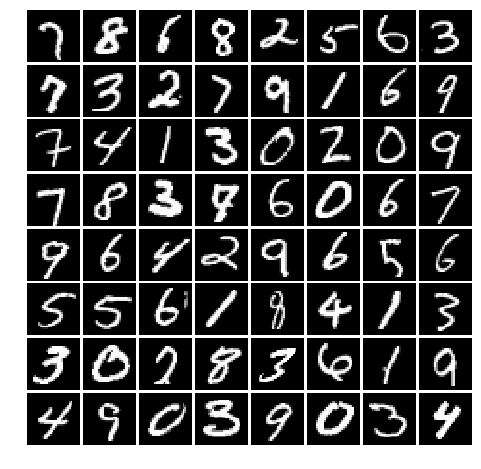

In [12]:
imgs, targets = next(iter(dataloader))
show_imgs(imgs)

# Train

[Epoch 0/200] [D loss: 0.605712] [G loss: 0.896762]


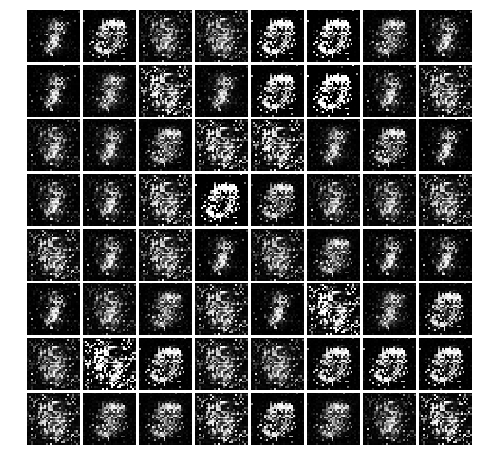

[Epoch 9/200] [D loss: 0.484659] [G loss: 1.775587]


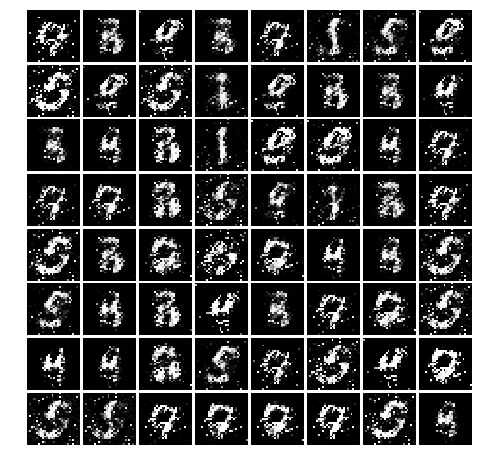

[Epoch 19/200] [D loss: 0.650508] [G loss: 1.741806]


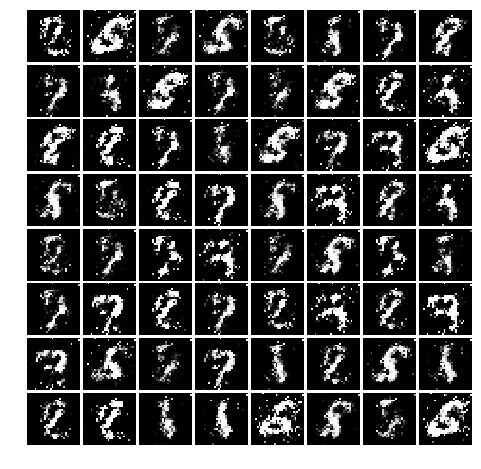

[Epoch 29/200] [D loss: 0.440583] [G loss: 1.377114]


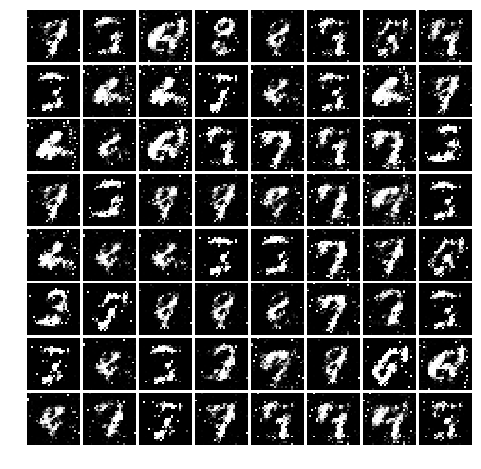

[Epoch 39/200] [D loss: 0.367237] [G loss: 2.118525]


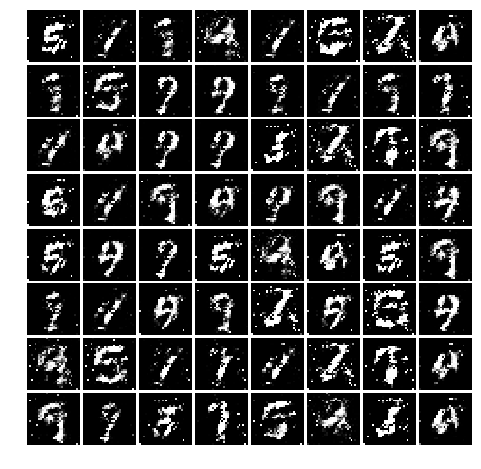

[Epoch 49/200] [D loss: 0.532502] [G loss: 0.853956]


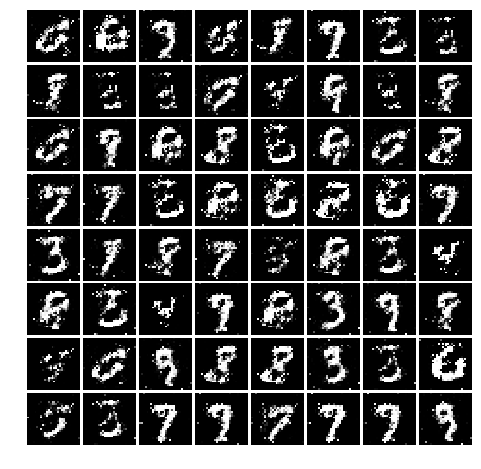

[Epoch 59/200] [D loss: 0.487995] [G loss: 2.274711]


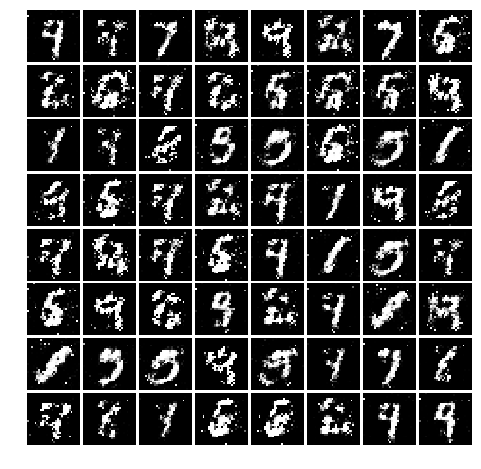

[Epoch 69/200] [D loss: 0.400513] [G loss: 1.379509]


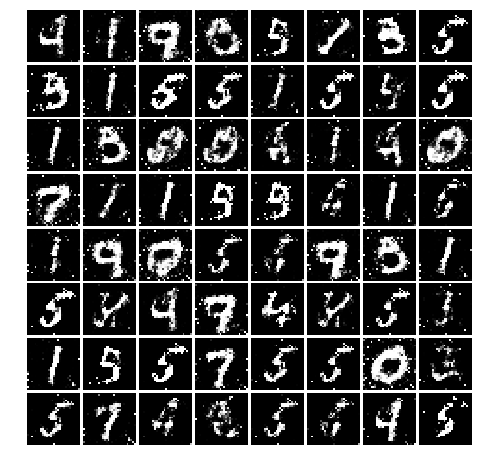

[Epoch 79/200] [D loss: 0.465727] [G loss: 1.173538]


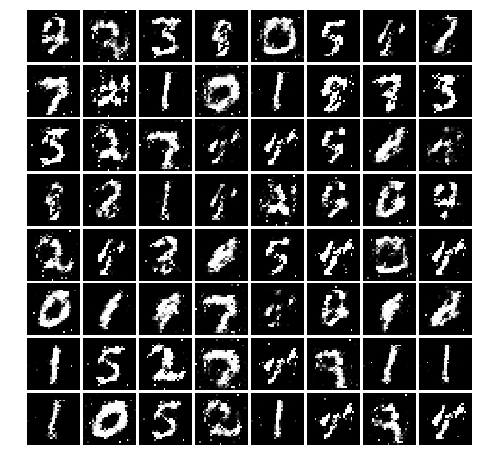

[Epoch 89/200] [D loss: 0.359367] [G loss: 1.735034]


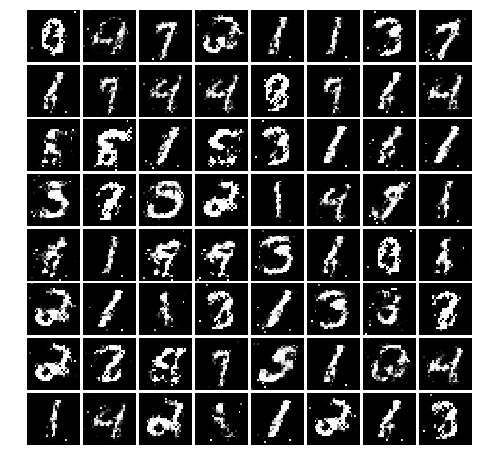

[Epoch 99/200] [D loss: 0.367816] [G loss: 1.879398]


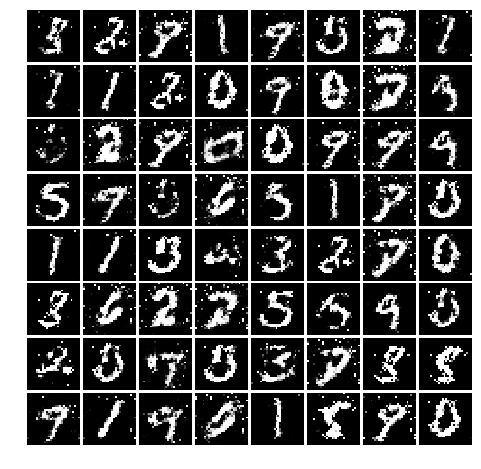

[Epoch 109/200] [D loss: 0.396477] [G loss: 1.646158]


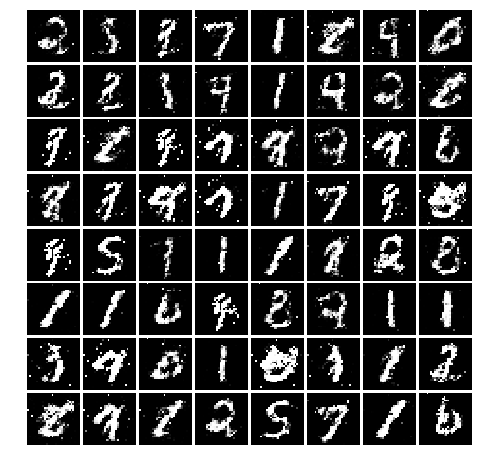

[Epoch 119/200] [D loss: 0.404098] [G loss: 1.695865]


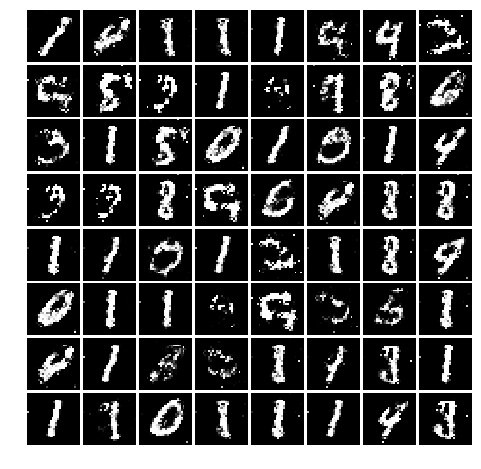

[Epoch 129/200] [D loss: 0.485539] [G loss: 1.106609]


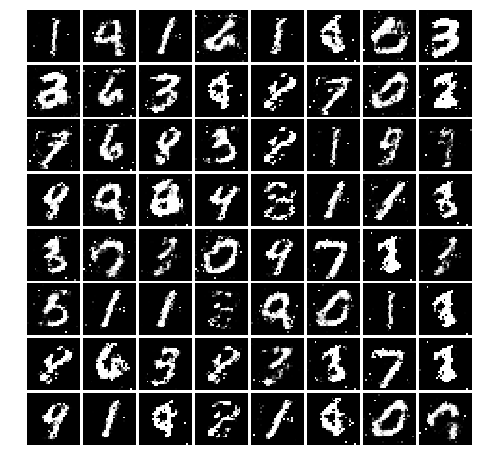

[Epoch 139/200] [D loss: 0.390200] [G loss: 1.601493]


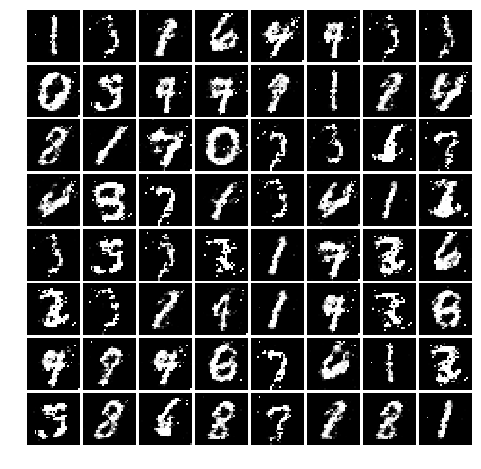

[Epoch 149/200] [D loss: 0.419858] [G loss: 1.481645]


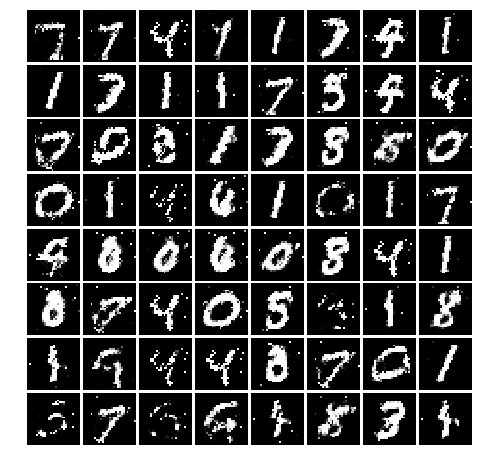

[Epoch 159/200] [D loss: 0.394940] [G loss: 1.934529]


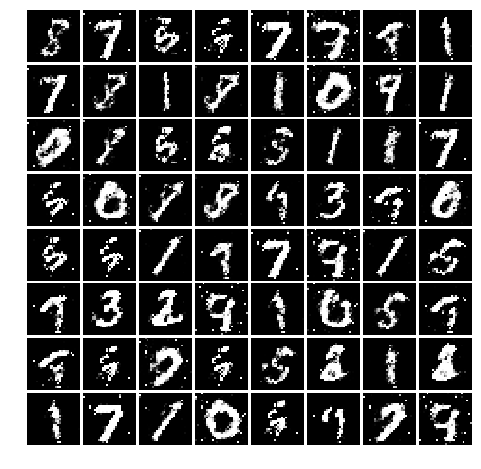

[Epoch 169/200] [D loss: 0.323471] [G loss: 1.516839]


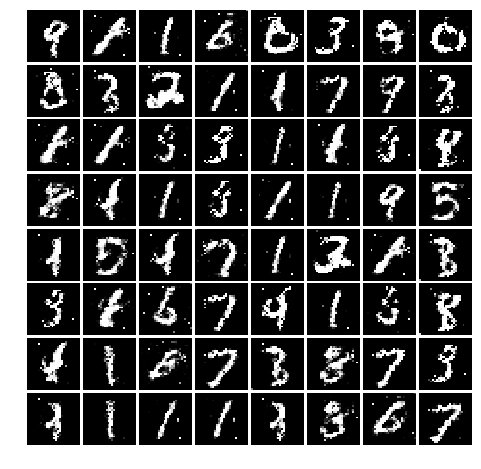

[Epoch 179/200] [D loss: 0.451418] [G loss: 1.575214]


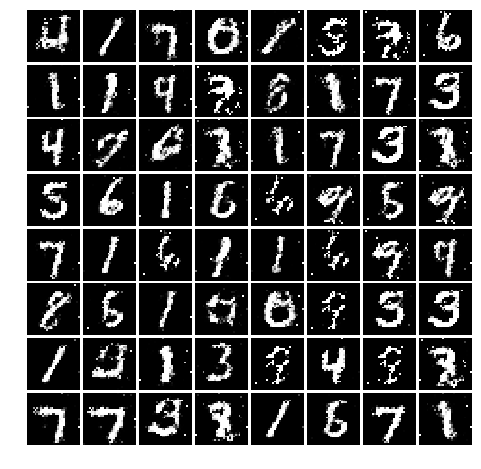

[Epoch 189/200] [D loss: 0.465354] [G loss: 2.649199]


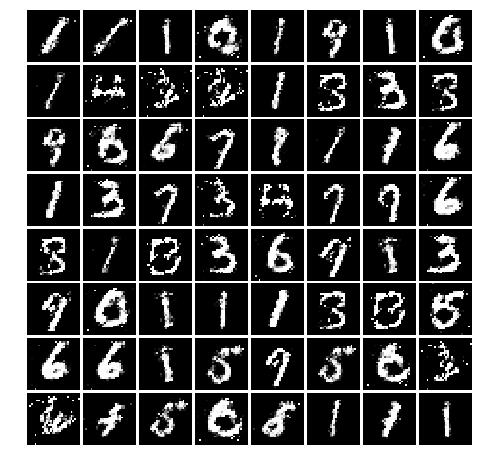

[Epoch 199/200] [D loss: 0.446956] [G loss: 2.331530]


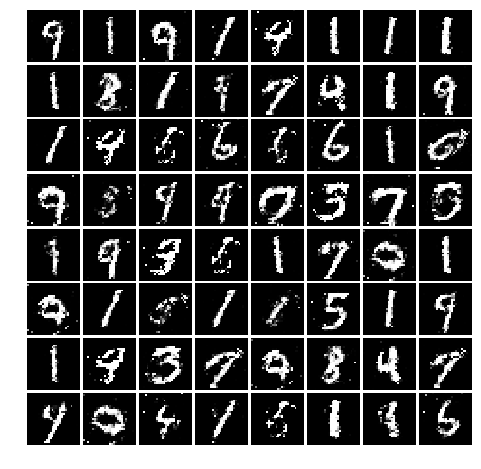

In [13]:
# Training
start_epo = 0
n_epochs = 200
print_freq = 10
G.train()
D.train()
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        batch_size = imgs.size(0)
        # Configure input
        real_imgs = imgs.type(Tensor)
        # Sample noise as generator input
        z = torch.zeros((batch_size,latent_dim)).normal_(0, 1).type(Tensor)
        # Generate a batch of images
        gen_imgs = G(z)
        # Adversarial ground truths
        valid = torch.ones((batch_size, 1)).type(Tensor)
        fake = torch.zeros((batch_size, 1)).type(Tensor)
        if (epoch+i)%2==0:
            # g_loss: Loss measures generator's ability to fool the discriminator
            g_loss = loss_fn(D(gen_imgs), valid)
            # g_loss: loss backward
            optimizer_G.zero_grad()
            g_loss.backward(retain_graph=True)
            optimizer_G.step()
        else:
            # d_loss: Measure discriminator's ability to classify real from generated samples
            real_loss = loss_fn(D(real_imgs), valid)
            fake_loss = loss_fn(D(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            # d_loss: loss backward        
            optimizer_D.zero_grad()
            d_loss.backward(retain_graph=True)
            optimizer_D.step()
        
    if epoch==0 or epoch%print_freq==(print_freq-1) or epoch==n_epochs-1:         
        print(
            "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, d_loss.item(), g_loss.item())
        )
        # save out
        model_name = "gan"
        this_epo_str = str(epoch+start_epo).zfill(4) 
        torch.save(G.state_dict(), f"{model_name}/model/G_{this_epo_str}")
        torch.save(D.state_dict(), f"{model_name}/model/D_{this_epo_str}")
        sample_img(G, dataloader, f"{model_name}/fig/{this_epo_str}.jpg")
